In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
file_path = "data (1).xlsx"
df = pd.read_excel(file_path, sheet_name="Worksheet")
df2 = pd.read_excel(file_path, sheet_name="second")
# df.head(2)

In [ ]:
def expand_by_impressions(df):
    """
    Expands the dataframe so each impression becomes its own row,
    with CTR converted to binary (0 for no click, 1 for click)

    Parameters:
    df (pandas.DataFrame): DataFrame with 'gender', 'CTR', and 'Impressions' columns

    Returns:
    pandas.DataFrame: Expanded DataFrame where each row represents one impression
    """
    # Initialize empty lists to store the expanded data
    expanded_gender = []
    expanded_ctr = []

    for _, row in df.iterrows():
        # Get the number of impressions for this row
        num_impressions = int(row['impressions'])

        # Calculate number of clicks
        clicks = 0 if pd.isna(row['CTR']) else int(row['CTR'])

        # Add gender and CTR values for each impression
        for i in range(num_impressions):
            expanded_gender.append(row['gender'])
            if i < clicks:
                expanded_ctr.append(1)  # Clicked impressions
            else:
                expanded_ctr.append(0)  # Non-clicked impressions

    # Create new dataframe with expanded data
    result_df = pd.DataFrame({
        'gender': expanded_gender,
        'CTR': expanded_ctr
    })

    return result_df
# Process the data
processed_df = expand_by_impressions(df2)

# Save to new CSV if needed
# processed_df.to_csv('processed_ctr_data.csv', index=False)

# Display first few rows and total count
print("First few rows:")
total_clicks = processed_df['CTR'].sum()

# Count the number of clicks (1's) per 'Campaign name'
clicks_per_campaign = processed_df.groupby('gender')['CTR'].sum()
print(clicks_per_campaign)
print("\nTotal number of rows:", len(processed_df))

First few rows:
gender
female      3
male       12
unknown     0
Name: CTR, dtype: int64

Total number of rows: 1124


In [ ]:
import pandas as pd

def calculate_gender_distribution(df):
    """Calculate gender distribution percentages"""
    gender_counts = df['gender'].value_counts(normalize=True) * 100
    return gender_counts

def most_common_age_group(df):
    """Find the most common age group"""
    return df['gender'].mode()[0]  # Assuming there is an 'age_group' column

def calculate_ctr_stats(df):
    """Calculate CTR statistics for each gender"""
    ctr_stats = df.groupby('gender')['CTR'].agg(['mean', 'std', 'count'])
    return ctr_stats

# Assuming df2 contains the necessary columns for gender, CTR, and age_group
processed_df = expand_by_impressions(df2)

# Population Size
population_size = len(processed_df)

# Gender Distribution
gender_distribution = calculate_gender_distribution(processed_df)

# Most Common Age Group
common_age_group = most_common_age_group(processed_df)

# CTR Statistics
ctr_stats = calculate_ctr_stats(processed_df)

# Display results
print("Population Size:", population_size)
print("\nGender Distribution (%):")
print(gender_distribution)

print("\nMost Common Age Group:", common_age_group)

print("\nCTR Statistics:")
print(ctr_stats)


Population Size: 1124

Gender Distribution (%):
gender
female     53.291815
male       46.530249
unknown     0.177936
Name: proportion, dtype: float64

Most Common Age Group: female

CTR Statistics:
             mean       std  count
gender                            
female   0.005008  0.070651    599
male     0.022945  0.149870    523
unknown  0.000000  0.000000      2


In [ ]:
total_clicks = df['Results'].sum()
total_impressions = df['Impressions'].sum()
total_no_clicks = total_impressions - total_clicks
print(f"Total number of people who clicked the link: {total_clicks}")
print(f"Total number of people who did not click the link: {total_no_clicks}")
print(f"Total number of people who saw the ad: {total_impressions}")

Total number of people who clicked the link: 15.0
Total number of people who did not click the link: 1109.0
Total number of people who saw the ad: 1124


In [ ]:
# Compute mean and standard deviation of CTR for the general case
ctr_mean = processed_df['CTR'].mean()
ctr_std = processed_df['CTR'].std()

print(f"General CTR Mean: {ctr_mean:.4f}")
print(f"General CTR Standard Deviation: {ctr_std:.4f}")


General CTR Mean: 0.0133
General CTR Standard Deviation: 0.1148


In [ ]:
import numpy as np
import scipy.stats as stats
import pandas as pd

def perform_campaign_ztest(df, campaign_a_name, campaign_b_name):
    """
    Performs a manual two-proportional z-test to compare CTRs between two campaigns

    Parameters:
    df (pandas.DataFrame): DataFrame containing 'Campaign name', 'Results', and 'Impressions' columns
    campaign_a_name (str): Name of the first campaign (e.g., male variant)
    campaign_b_name (str): Name of the second campaign (e.g., female variant)

    Returns:
    dict: Dictionary containing test statistics and results
    """
    # Clean campaign names
    df['Campaign name'] = df['Campaign name'].str.lower().str.strip()
    campaign_a_name = campaign_a_name.lower().strip()
    campaign_b_name = campaign_b_name.lower().strip()

    # Filter for relevant campaigns and group by Campaign name
    campaign_stats = df[df['Campaign name'].isin([campaign_a_name, campaign_b_name])]
    campaign_stats = campaign_stats.groupby('Campaign name', as_index=True).agg({
        'Results': 'sum',
        'Impressions': 'sum'
    })

    # Extract values
    campaign_a_clicks = campaign_stats.loc[campaign_a_name, 'Results']
    campaign_a_impressions = campaign_stats.loc[campaign_a_name, 'Impressions']
    campaign_b_clicks = campaign_stats.loc[campaign_b_name, 'Results']
    campaign_b_impressions = campaign_stats.loc[campaign_b_name, 'Impressions']

    if campaign_a_name not in campaign_stats.index or campaign_b_name not in campaign_stats.index:
      raise ValueError("One or both campaign names do not exist in the data after processing.")

    # Calculate CTRs
    p1 = campaign_a_clicks / campaign_a_impressions  # campaign A proportion
    p2 = campaign_b_clicks / campaign_b_impressions  # campaign B proportion

    # Calculate pooled proportion
    p_pooled = (campaign_a_clicks + campaign_b_clicks) / (campaign_a_impressions + campaign_b_impressions)

    # Calculate standard error
    se = np.sqrt(p_pooled * (1 - p_pooled) * (1/campaign_a_impressions + 1/campaign_b_impressions))

    # Calculate z-statistic
    z_stat = (p1 - p2) / se

    # Calculate two-tailed p-value
    p_value = 2 * (1 - stats.norm.cdf(np.abs(z_stat)))

    return {
        'campaign_a_ctr': p1 * 100,
        'campaign_b_ctr': p2 * 100,
        'z_statistic': z_stat,
        'p_value': p_value,
        'sample_sizes': {
            'campaign_a_impressions': campaign_a_impressions,
            'campaign_b_impressions': campaign_b_impressions,
            'campaign_a_clicks': campaign_a_clicks,
            'campaign_b_clicks': campaign_b_clicks
        }
    }

def print_test_results(results, campaign_a_name, campaign_b_name, alpha=0.05):
    """
    Prints formatted results of the two-proportional z-test
    """
    print(f"\n=== Two-Proportional Z-Test Results: {campaign_a_name} vs {campaign_b_name} ===")

    # CTR Comparison
    print("\nCTR Comparison:")
    print(f"{campaign_a_name} CTR: {results['campaign_a_ctr']:.2f}%")
    print(f"{campaign_b_name} CTR: {results['campaign_b_ctr']:.2f}%")
    print(f"Difference: {(results['campaign_a_ctr'] - results['campaign_b_ctr']):.2f}%")

    # Test Statistics
    print("\nTest Statistics:")
    print(f"Z-statistic: {results['z_statistic']:.4f}")
    print(f"P-value: {results['p_value']:.4f}")

    # Sample Sizes
    print("\nSample Sizes:")
    print(f"{campaign_a_name}: {int(results['sample_sizes']['campaign_a_clicks'])} clicks out of {int(results['sample_sizes']['campaign_a_impressions'])} impressions")
    print(f"{campaign_b_name}: {int(results['sample_sizes']['campaign_b_clicks'])} clicks out of {int(results['sample_sizes']['campaign_b_impressions'])} impressions")

    # Interpretation
    print("\n=== Interpretation ===")
    if results['p_value'] < alpha:
        print(f"At α = {alpha}, we reject the null hypothesis.")
        print(f"There is significant evidence that {campaign_a_name} CTR is different from {campaign_b_name} CTR.")
    else:
        print(f"At α = {alpha}, we fail to reject the null hypothesis.")
        print(f"There is insufficient evidence that {campaign_a_name} CTR is different from {campaign_b_name} CTR.")

# Example usage:
campaign_a_name = "New Traffic Campaign Hagorem Project 2 Insurance Agents"
campaign_b_name = "Test - New Traffic Campaign Hagorem Project 2 Insurance Agents"
results = perform_campaign_ztest(df, campaign_a_name, campaign_b_name)
print_test_results(results, campaign_a_name, campaign_b_name)


=== Two-Proportional Z-Test Results: New Traffic Campaign Hagorem Project 2 Insurance Agents vs Test - New Traffic Campaign Hagorem Project 2 Insurance Agents ===

CTR Comparison:
New Traffic Campaign Hagorem Project 2 Insurance Agents CTR: 2.29%
Test - New Traffic Campaign Hagorem Project 2 Insurance Agents CTR: 0.50%
Difference: 1.78%

Test Statistics:
Z-statistic: 2.6018
P-value: 0.0093

Sample Sizes:
New Traffic Campaign Hagorem Project 2 Insurance Agents: 12 clicks out of 525 impressions
Test - New Traffic Campaign Hagorem Project 2 Insurance Agents: 3 clicks out of 599 impressions

=== Interpretation ===
At α = 0.05, we reject the null hypothesis.
There is significant evidence that New Traffic Campaign Hagorem Project 2 Insurance Agents CTR is different from Test - New Traffic Campaign Hagorem Project 2 Insurance Agents CTR.


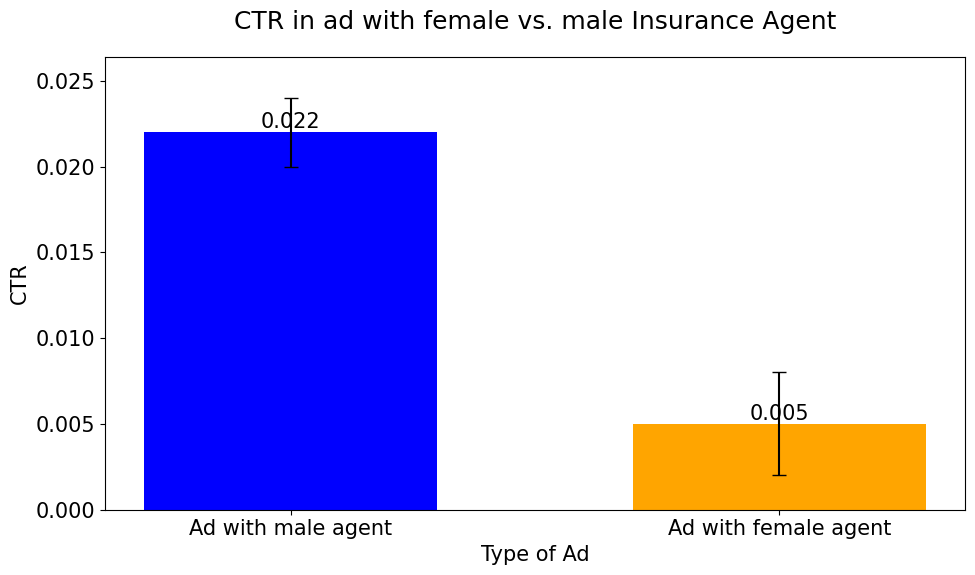

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
categories = ['Ad with male agent', 'Ad with female agent']
values = [0.022, 0.005]
errors = [0.002, 0.003]

# Calculate max y value with 20% padding
max_y = max(values) * 1.2

# Create figure and axis
plt.figure(figsize=(10, 6))

# Increase font sizes
plt.rcParams.update({'font.size': 15})  # Increase base font size by 50%

# Create bars
bars = plt.bar(categories, values, color=['blue', 'orange'], width=0.6)

# Add error bars
plt.errorbar(x=range(len(categories)), y=values, yerr=errors, fmt='none', color='black', capsize=5)

# Customize the plot with larger text
plt.title('CTR in ad with female vs. male Insurance Agent', pad=20, fontsize=18)
plt.ylabel('CTR', fontsize=15)
plt.xlabel('Type of Ad', fontsize=15)

# Set y-axis limits based on max value
plt.ylim(0, max_y)

# Add value labels on top of each bar with larger font
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom',
             fontsize=15)

# Increase tick label sizes
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

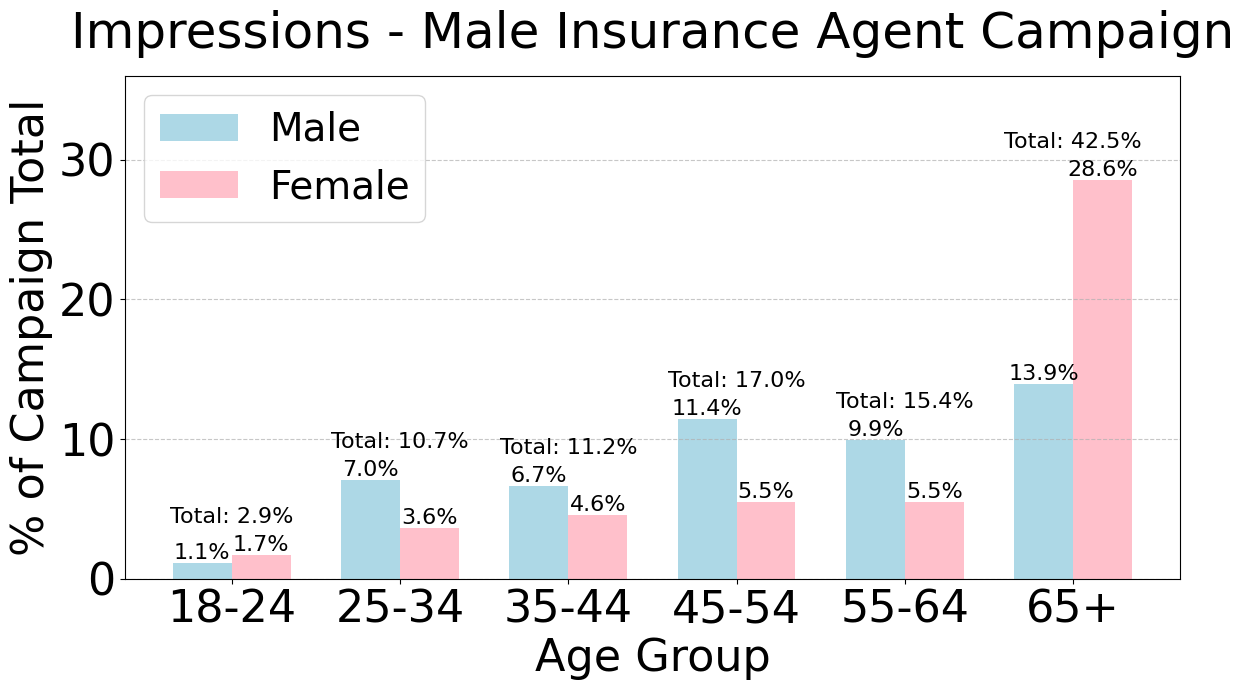

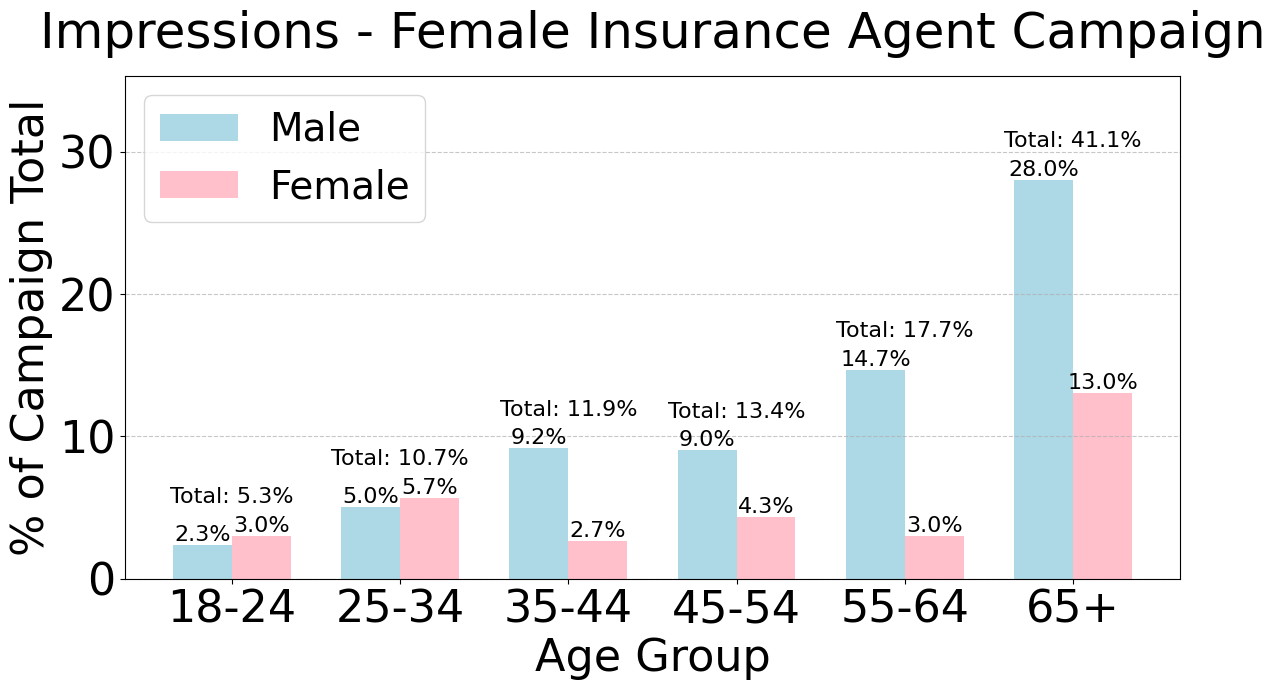

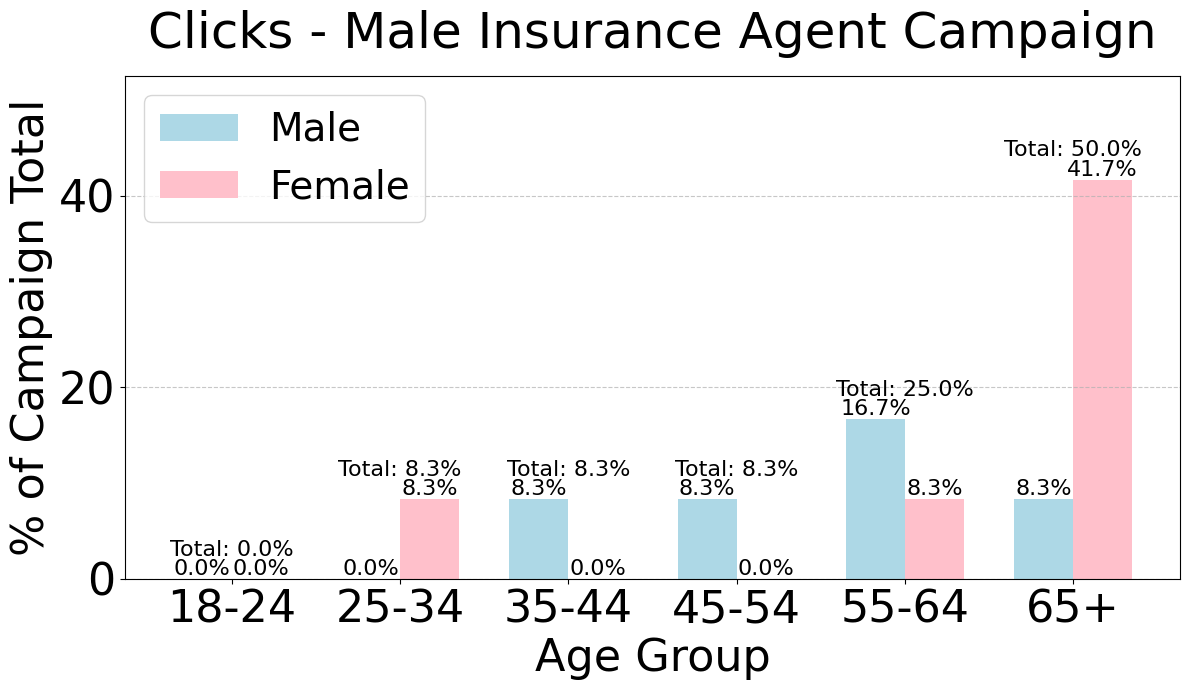

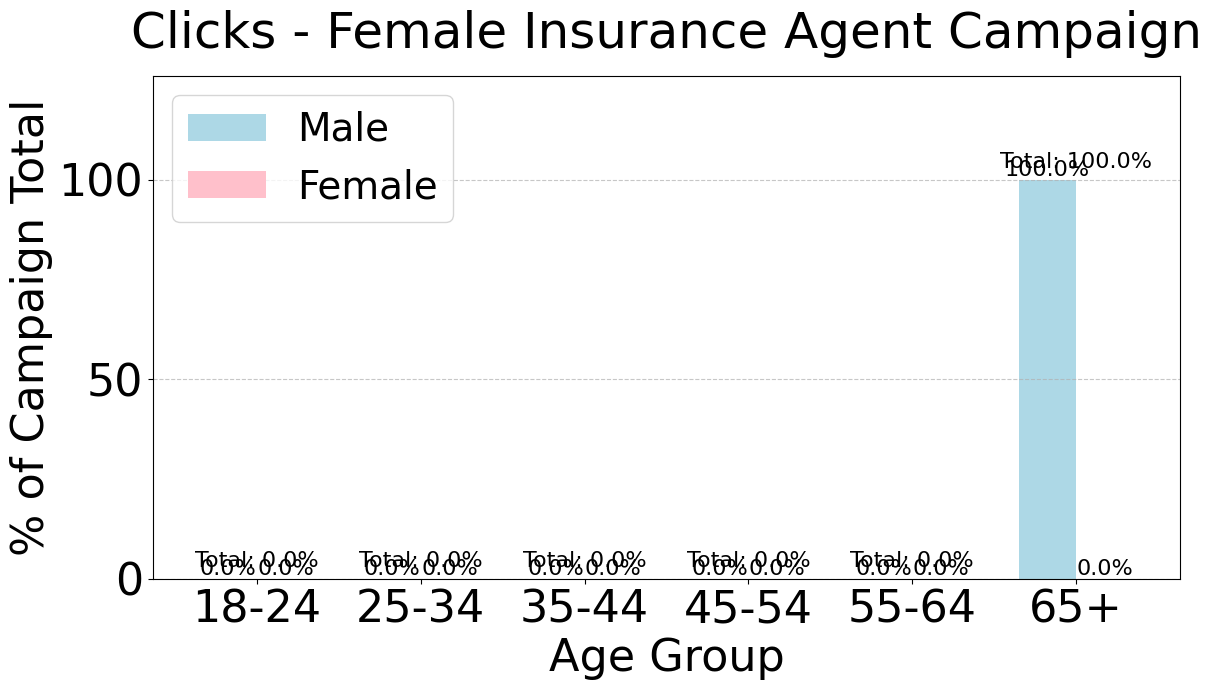

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def create_campaign_plots(df):
    # Define campaign names
    female_campaign = "Test - New Traffic Campaign Hagorem Project 2"
    male_campaign = "New Traffic Campaign Hagorem Project 2"

    # Filter data for each campaign
    female_data = df[df['Campaign name'].str.startswith(female_campaign)].copy()
    male_data = df[df['Campaign name'].str.startswith(male_campaign)].copy()

    # Set age order
    age_order = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']

    def calculate_metrics(data):
        total_impressions = data['Impressions'].sum()
        impressions_by_age_gender = data.groupby(['Age', 'Gender'])['Impressions'].sum().unstack(fill_value=0)
        impressions_pct = (impressions_by_age_gender / total_impressions * 100).reindex(age_order, fill_value=0)

        total_clicks = data['Results'].fillna(0).sum()
        clicks_by_age_gender = data.groupby(['Age', 'Gender'])['Results'].sum().unstack(fill_value=0)
        clicks_pct = (clicks_by_age_gender / total_clicks * 100) if total_clicks > 0 else clicks_by_age_gender

        return impressions_pct, clicks_pct, impressions_by_age_gender, clicks_by_age_gender

    # Calculate metrics
    impressions_pct_female, clicks_pct_female, impressions_female, clicks_female = calculate_metrics(female_data)
    impressions_pct_male, clicks_pct_male, impressions_male, clicks_male = calculate_metrics(male_data)

    # Set the x-axis for the plots
    x = np.arange(len(age_order))
    width = 0.35

    def plot_bars(data_pct, raw_data, title):
        """Helper function to plot bars with value labels"""
        fig, ax = plt.subplots(figsize=(12, 7))

        if 'male' in data_pct.columns and 'female' in data_pct.columns:
            # Plot bars
            male_bars = ax.bar(x - width/2, data_pct['male'], width, color='lightblue', label='Male')
            female_bars = ax.bar(x + width/2, data_pct['female'], width, color='pink', label='Female')

            # Add value labels for each bar
            def add_labels(bars, raw_values):
                for idx, rect in enumerate(bars):
                    height = rect.get_height()
                    male_val = raw_values['male'].iloc[idx]
                    female_val = raw_values['female'].iloc[idx]
                    total = male_val + female_val

                    # Add single value for each bar (male or female)
                    if bars == male_bars:
                        ax.text(rect.get_x() + rect.get_width()/2., height,
                               f'{male_val:.1f}%',
                               ha='center', va='bottom', fontsize=16)
                    else:
                        ax.text(rect.get_x() + rect.get_width()/2., height,
                               f'{female_val:.1f}%',
                               ha='center', va='bottom', fontsize=16)

                    # Add total only once, above both bars
                    if bars == male_bars:
                        ax.text((rect.get_x() + female_bars[idx].get_x() + rect.get_width())/2.,
                               max(height, female_bars[idx].get_height()) + 2,
                               f'Total: {total:.1f}%',
                               ha='center', va='bottom', fontsize=16)

            add_labels(male_bars, data_pct)
            add_labels(female_bars, data_pct)

            # Customize plot with larger text
            ax.set_title(title, fontsize=36, pad=20)
            ax.set_xticks(x)
            ax.set_xticklabels(age_order, fontsize=32)
            ax.set_xlabel('Age Group', fontsize=32)
            ax.set_ylabel('% of Campaign Total', fontsize=32)
            ax.legend(fontsize=28)
            ax.grid(axis='y', linestyle='--', alpha=0.7)

            # Set y-axis tick label size to match x-axis
            ax.tick_params(axis='y', labelsize=32)

            # Adjust y-axis to accommodate labels
            current_ymax = ax.get_ylim()[1]
            ax.set_ylim(0, max(current_ymax * 1.2, 30))

            plt.tight_layout()
            plt.show()

    # Plot and display each campaign separately
    plot_bars(impressions_pct_male, impressions_pct_male, 'Impressions - Male Insurance Agent Campaign')
    plot_bars(impressions_pct_female, impressions_pct_female, 'Impressions - Female Insurance Agent Campaign')
    plot_bars(clicks_pct_male, clicks_pct_male, 'Clicks - Male Insurance Agent Campaign')
    plot_bars(clicks_pct_female, clicks_pct_female, 'Clicks - Female Insurance Agent Campaign')

# Call the function
create_campaign_plots(df)

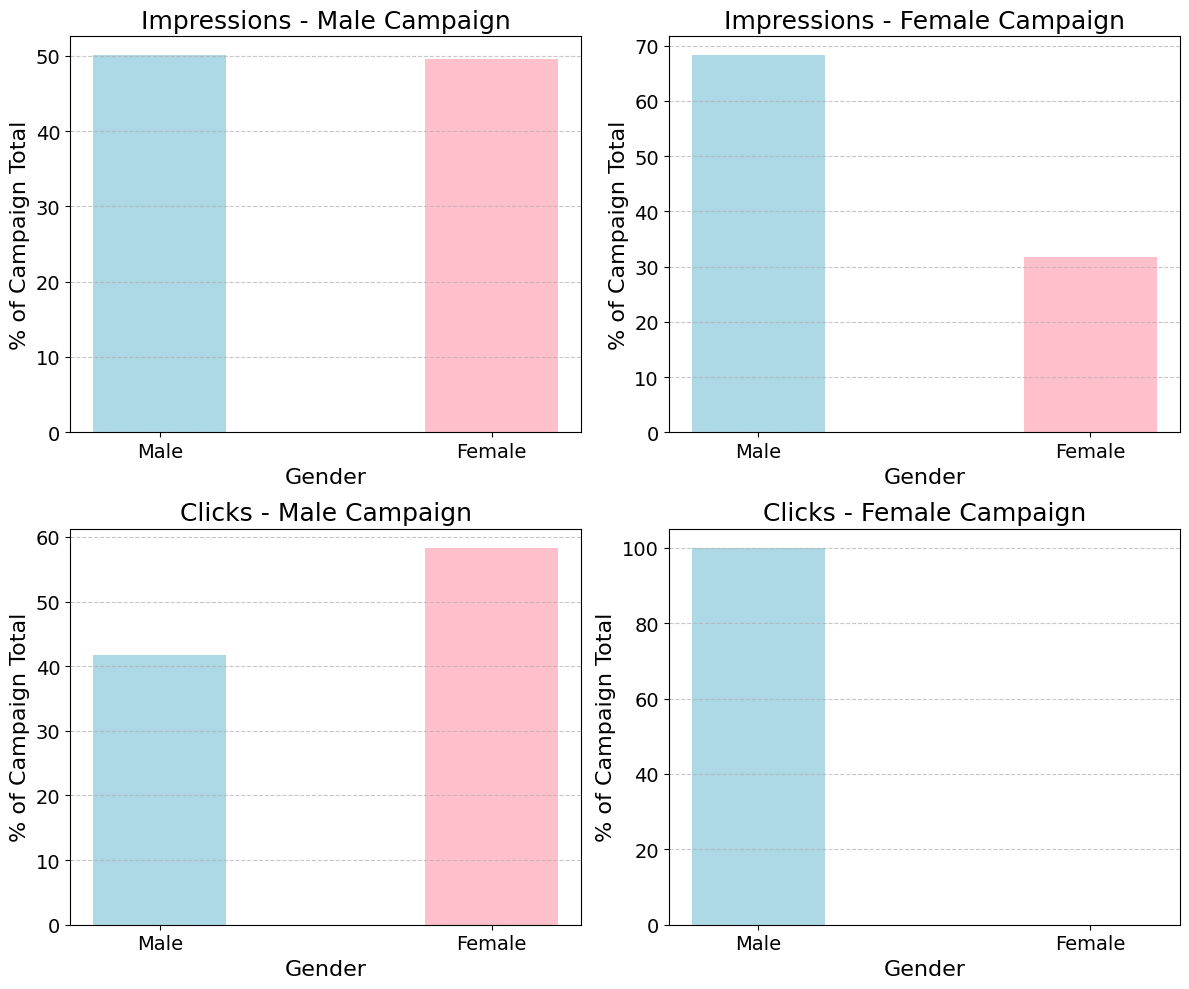

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def create_campaign_plots(df):
    # Identify unique campaign names
    campaign_names = df['Campaign name'].str.split().str[:5].str.join(' ').unique()
    if len(campaign_names) < 2:
        raise ValueError("Expected at least two distinct campaigns for A/B testing")

    # Assign campaigns dynamically
    male_campaign, female_campaign = campaign_names[:2]

    # Filter data for each campaign
    female_data = df[df['Campaign name'].str.startswith(female_campaign)].copy()
    male_data = df[df['Campaign name'].str.startswith(male_campaign)].copy()

    def calculate_metrics(data):
        total_impressions = data['Impressions'].sum()
        impressions_by_gender = data.groupby('Gender')['Impressions'].sum()
        impressions_pct = (impressions_by_gender / total_impressions * 100) if total_impressions > 0 else impressions_by_gender

        total_clicks = data['Results'].fillna(0).sum()
        clicks_by_gender = data.groupby('Gender')['Results'].sum()
        clicks_pct = (clicks_by_gender / total_clicks * 100) if total_clicks > 0 else clicks_by_gender

        return impressions_pct, clicks_pct

    # Calculate metrics
    impressions_pct_female, clicks_pct_female = calculate_metrics(female_data)
    impressions_pct_male, clicks_pct_male = calculate_metrics(male_data)

    # Create figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    gender_labels = ['Male', 'Female']
    x = np.arange(len(gender_labels))
    width = 0.4

    def plot_bars(ax, data, title):
        ax.bar(x, [data.get('male', 0), data.get('female', 0)], width, color=['lightblue', 'pink'], tick_label=gender_labels)
        ax.set_title(title, fontsize=18)
        ax.set_ylabel('% of Campaign Total', fontsize=16)
        ax.set_xlabel('Gender', fontsize=16)
        ax.grid(axis='y', linestyle='--', alpha=0.7)

        # Adjusting font sizes
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)

    # Plot data
    plot_bars(axes[0, 0], impressions_pct_male, 'Impressions - Male Campaign')
    plot_bars(axes[0, 1], impressions_pct_female, 'Impressions - Female Campaign')
    plot_bars(axes[1, 0], clicks_pct_male, 'Clicks - Male Campaign')
    plot_bars(axes[1, 1], clicks_pct_female, 'Clicks - Female Campaign')

    # Adjust layout and save figure
    plt.tight_layout()
    plt.savefig('campaign_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

# Assuming df is already defined, call the function
create_campaign_plots(df)


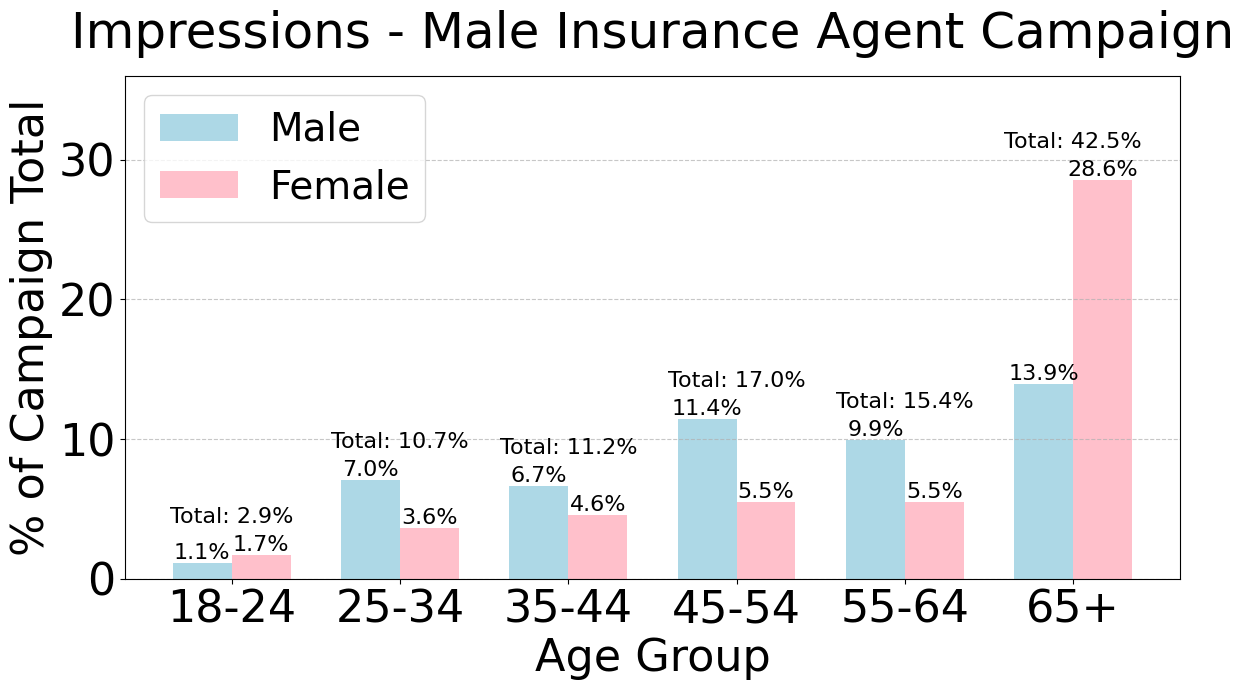

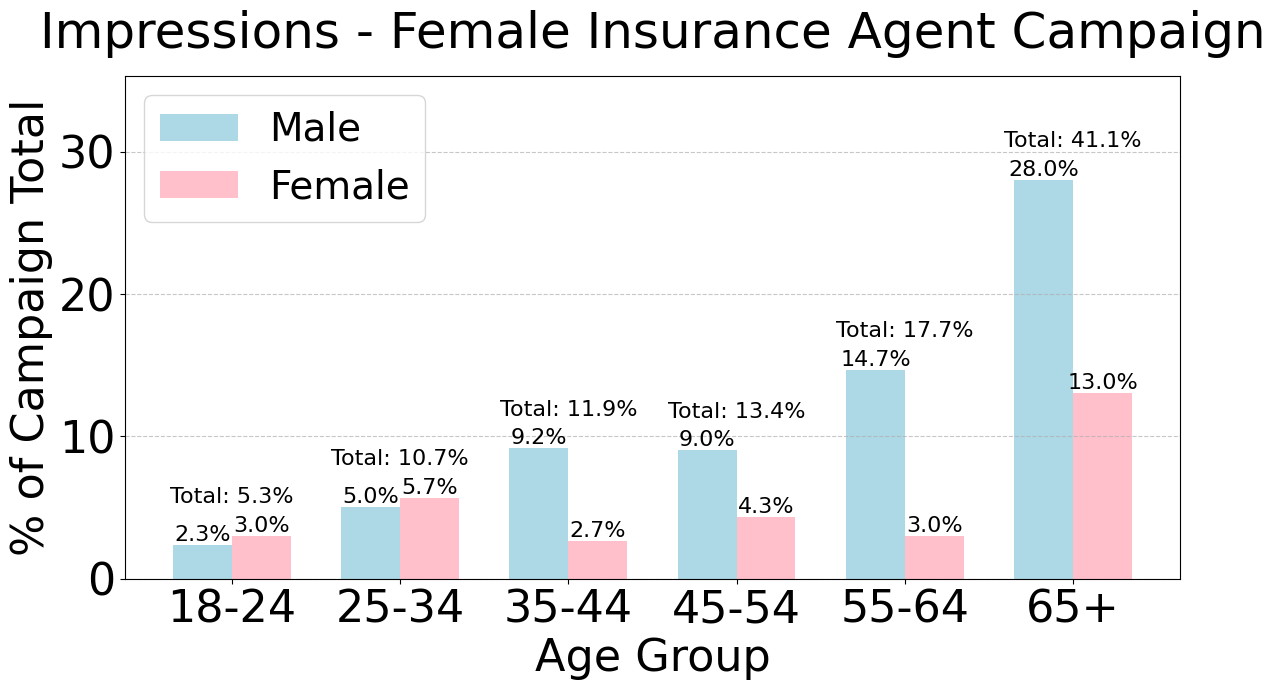

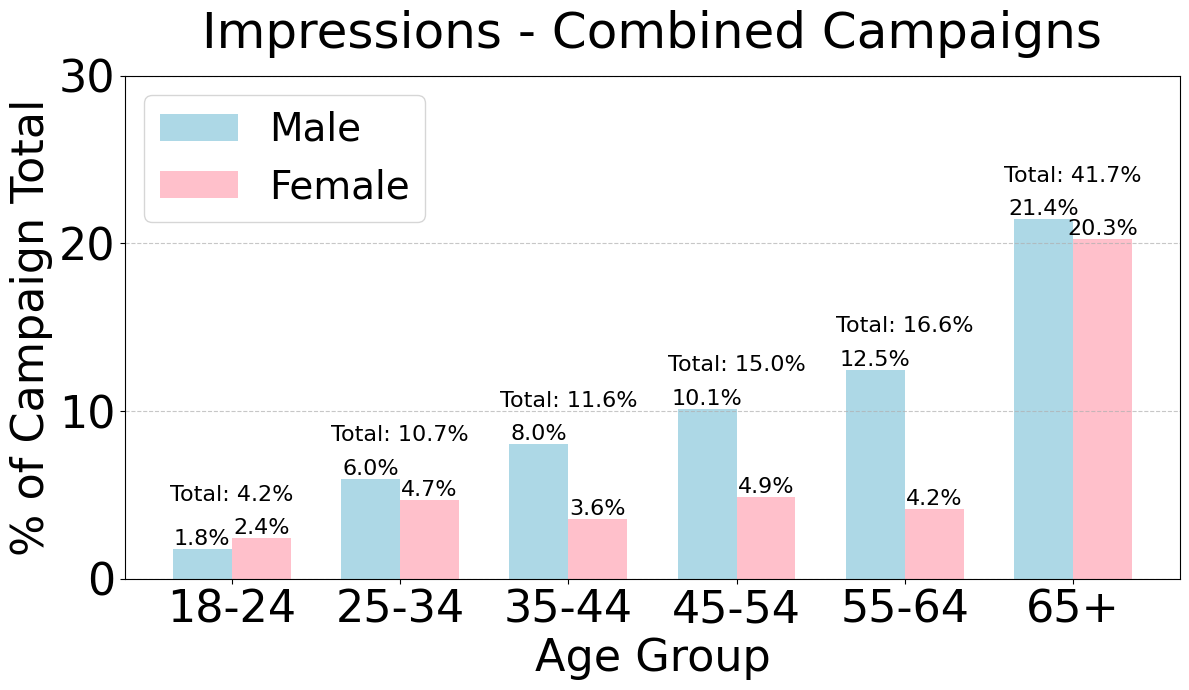

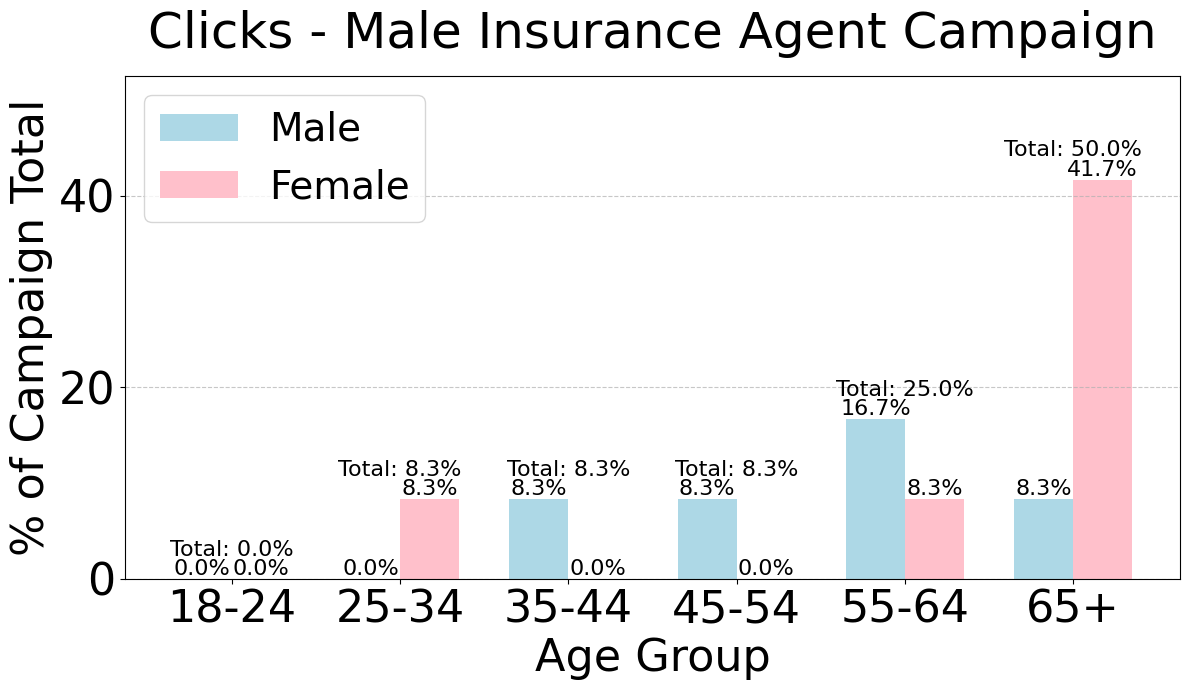

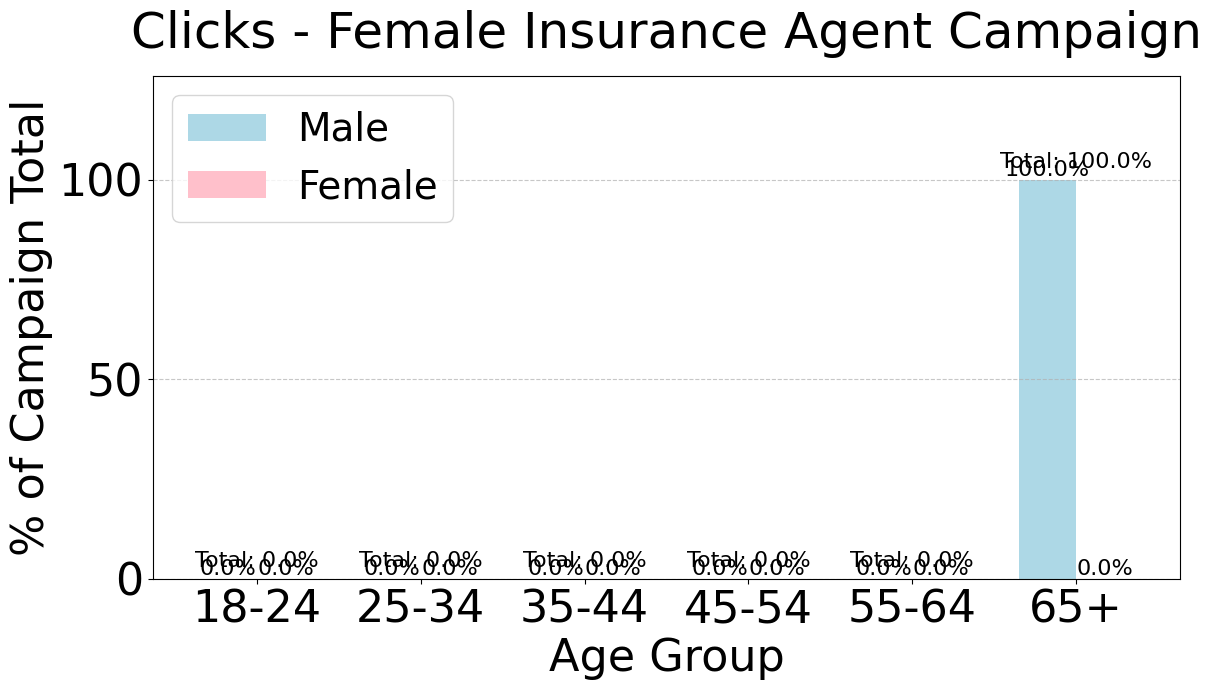

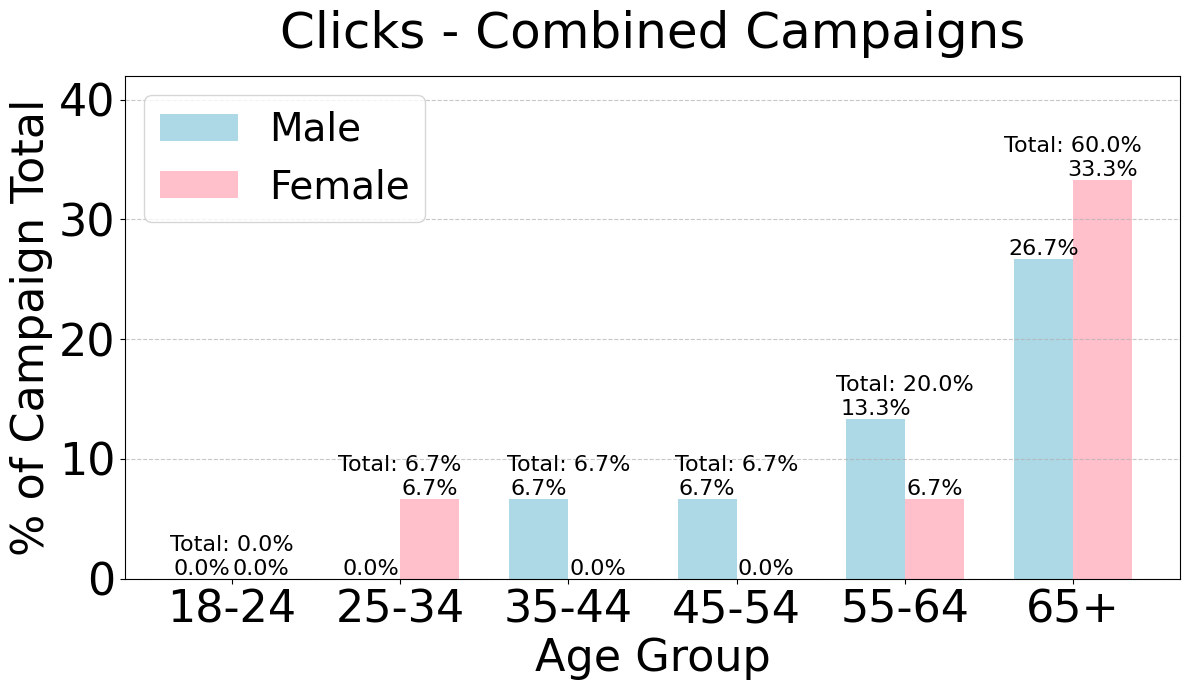

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def create_campaign_plots(df):
    # Define campaign names
    female_campaign = "Test - New Traffic Campaign Hagorem Project 2"
    male_campaign = "New Traffic Campaign Hagorem Project 2"

    # Filter data for each campaign
    female_data = df[df['Campaign name'].str.startswith(female_campaign)].copy()
    male_data = df[df['Campaign name'].str.startswith(male_campaign)].copy()

    # Combined data
    combined_data = pd.concat([female_data, male_data])

    # Set age order
    age_order = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']

    def calculate_metrics(data):
        total_impressions = data['Impressions'].sum()
        impressions_by_age_gender = data.groupby(['Age', 'Gender'])['Impressions'].sum().unstack(fill_value=0)
        impressions_pct = (impressions_by_age_gender / total_impressions * 100).reindex(age_order, fill_value=0)

        total_clicks = data['Results'].fillna(0).sum()
        clicks_by_age_gender = data.groupby(['Age', 'Gender'])['Results'].sum().unstack(fill_value=0)
        clicks_pct = (clicks_by_age_gender / total_clicks * 100) if total_clicks > 0 else clicks_by_age_gender

        return impressions_pct, clicks_pct, impressions_by_age_gender, clicks_by_age_gender

    # Calculate metrics
    impressions_pct_female, clicks_pct_female, impressions_female, clicks_female = calculate_metrics(female_data)
    impressions_pct_male, clicks_pct_male, impressions_male, clicks_male = calculate_metrics(male_data)
    impressions_pct_combined, clicks_pct_combined, impressions_combined, clicks_combined = calculate_metrics(combined_data)

    # Set the x-axis for the plots
    x = np.arange(len(age_order))
    width = 0.35

    def plot_bars(data_pct, raw_data, title):
        """Helper function to plot bars with value labels"""
        fig, ax = plt.subplots(figsize=(12, 7))

        if 'male' in data_pct.columns and 'female' in data_pct.columns:
            # Plot bars
            male_bars = ax.bar(x - width/2, data_pct['male'], width, color='lightblue', label='Male')
            female_bars = ax.bar(x + width/2, data_pct['female'], width, color='pink', label='Female')

            # Add value labels for each bar
            def add_labels(bars, raw_values):
                for idx, rect in enumerate(bars):
                    height = rect.get_height()
                    male_val = raw_values['male'].iloc[idx]
                    female_val = raw_values['female'].iloc[idx]
                    total = male_val + female_val

                    # Add single value for each bar (male or female)
                    if bars == male_bars:
                        ax.text(rect.get_x() + rect.get_width()/2., height,
                               f'{male_val:.1f}%',
                               ha='center', va='bottom', fontsize=16)
                    else:
                        ax.text(rect.get_x() + rect.get_width()/2., height,
                               f'{female_val:.1f}%',
                               ha='center', va='bottom', fontsize=16)

                    # Add total only once, above both bars
                    if bars == male_bars:
                        ax.text((rect.get_x() + female_bars[idx].get_x() + rect.get_width())/2.,
                               max(height, female_bars[idx].get_height()) + 2,
                               f'Total: {total:.1f}%',
                               ha='center', va='bottom', fontsize=16)

            add_labels(male_bars, data_pct)
            add_labels(female_bars, data_pct)

            # Customize plot with larger text
            ax.set_title(title, fontsize=36, pad=20)
            ax.set_xticks(x)
            ax.set_xticklabels(age_order, fontsize=32)
            ax.set_xlabel('Age Group', fontsize=32)
            ax.set_ylabel('% of Campaign Total', fontsize=32)
            ax.legend(fontsize=28)
            ax.grid(axis='y', linestyle='--', alpha=0.7)

            # Set y-axis tick label size to match x-axis
            ax.tick_params(axis='y', labelsize=32)

            # Adjust y-axis to accommodate labels
            current_ymax = ax.get_ylim()[1]
            ax.set_ylim(0, max(current_ymax * 1.2, 30))

            plt.tight_layout()
            plt.show()

    # Plot and display each campaign separately and combined
    plot_bars(impressions_pct_male, impressions_pct_male, 'Impressions - Male Insurance Agent Campaign')
    plot_bars(impressions_pct_female, impressions_pct_female, 'Impressions - Female Insurance Agent Campaign')
    plot_bars(impressions_pct_combined, impressions_pct_combined, 'Impressions - Combined Campaigns')
    plot_bars(clicks_pct_male, clicks_pct_male, 'Clicks - Male Insurance Agent Campaign')
    plot_bars(clicks_pct_female, clicks_pct_female, 'Clicks - Female Insurance Agent Campaign')
    plot_bars(clicks_pct_combined, clicks_pct_combined, 'Clicks - Combined Campaigns')

# Call the function
create_campaign_plots(df)